In [3]:
# Load dataset
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

In [4]:

# Add project root directory to Python path
root_path = Path.cwd().parent
sys.path.insert(0, str(root_path))

from neurokit import *

In [5]:
# Load and preprocess MNIST
print("Loading MNIST dataset...")
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Flatten images: (N, 28, 28) -> (N, 784)
X_train = X_train.reshape(-1, 784).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 784).astype(np.float32) / 255.0

print(f"Data shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")

Loading MNIST dataset...
Data shapes - X_train: (60000, 784), X_test: (10000, 784)


In [6]:
# Train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Split - Train: {X_tr.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Split - Train: (48000, 784), Val: (12000, 784), Test: (10000, 784)


In [7]:

# Simple MLP model
class MNISTModel(Module):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(784, 128)
        self.relu1 = ReLU()
        self.fc2 = Linear(128, 64)
        self.relu2 = ReLU()
        self.fc3 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [8]:
model = MNISTModel()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

print("\nModel created:")
print(f"  Layer 1: Linear(784 -> 128)")
print(f"  Layer 2: Linear(128 -> 64)")
print(f"  Layer 3: Linear(64 -> 10)")


Model created:
  Layer 1: Linear(784 -> 128)
  Layer 2: Linear(128 -> 64)
  Layer 3: Linear(64 -> 10)


In [9]:
# Training configuration
epochs = 5
batch_size = 128
train_losses, train_accs, val_accs = [], [], []

print(f"\nStarting training for {epochs} epochs...")

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    num_batches = 0
    
    # Mini-batch training
    indices = np.arange(len(X_tr))
    np.random.shuffle(indices)
    
    for i in range(0, len(X_tr), batch_size):
        batch_idx = indices[i:i+batch_size]
        X_batch = Tensor(X_tr[batch_idx])
        y_batch = Tensor(y_tr[batch_idx])
        
        # Forward
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        epoch_loss += loss.data.item()
        pred = np.argmax(logits.data, axis=1)
        correct += np.sum(pred == y_tr[batch_idx])
        total += len(batch_idx)
        num_batches += 1
        
        if num_batches % 50 == 0:
            print(f"  Epoch {epoch} - Batch {num_batches}/{len(X_tr)//batch_size}")
    
    # Epoch metrics
    avg_loss = epoch_loss / num_batches
    train_acc = correct / total
    
    # Validation
    model.eval()
    val_logits = model(Tensor(X_val))
    val_pred = np.argmax(val_logits.data, axis=1)
    val_acc = np.mean(val_pred == y_val)
    
    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch}/{epochs} | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Starting training for 5 epochs...
  Epoch 1 - Batch 50/375
  Epoch 1 - Batch 100/375
  Epoch 1 - Batch 150/375
  Epoch 1 - Batch 200/375
  Epoch 1 - Batch 250/375
  Epoch 1 - Batch 300/375
  Epoch 1 - Batch 350/375
Epoch 1/5 | Loss: 0.4811 | Train Acc: 0.8648 | Val Acc: 0.9275
  Epoch 2 - Batch 50/375
  Epoch 2 - Batch 100/375
  Epoch 2 - Batch 150/375
  Epoch 2 - Batch 200/375
  Epoch 2 - Batch 250/375
  Epoch 2 - Batch 300/375
  Epoch 2 - Batch 350/375
Epoch 2/5 | Loss: 0.2032 | Train Acc: 0.9420 | Val Acc: 0.9488
  Epoch 3 - Batch 50/375
  Epoch 3 - Batch 100/375
  Epoch 3 - Batch 150/375
  Epoch 3 - Batch 200/375
  Epoch 3 - Batch 250/375
  Epoch 3 - Batch 300/375
  Epoch 3 - Batch 350/375
Epoch 3/5 | Loss: 0.1476 | Train Acc: 0.9560 | Val Acc: 0.9595
  Epoch 4 - Batch 50/375
  Epoch 4 - Batch 100/375
  Epoch 4 - Batch 150/375
  Epoch 4 - Batch 200/375
  Epoch 4 - Batch 250/375
  Epoch 4 - Batch 300/375
  Epoch 4 - Batch 350/375
Epoch 4/5 | Loss: 0.1136 | Train Acc: 0.9663 | Val A


Evaluating on test set...
Test Accuracy: 0.9692


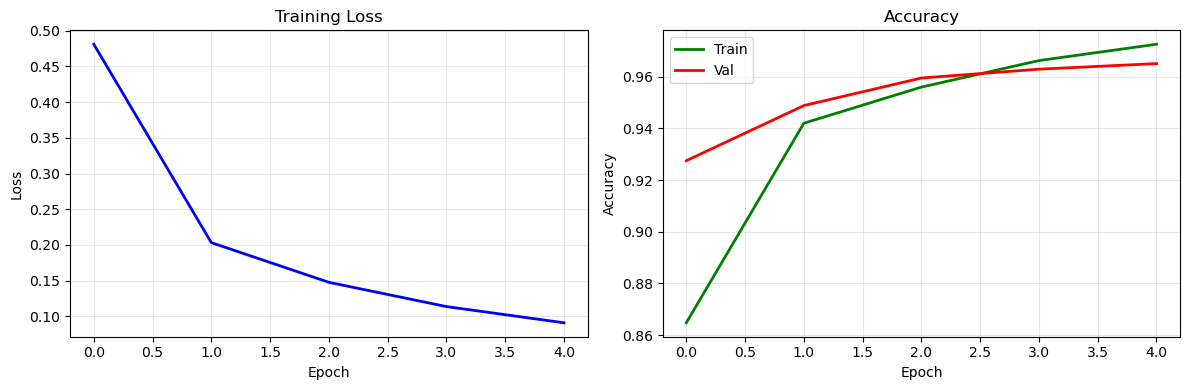

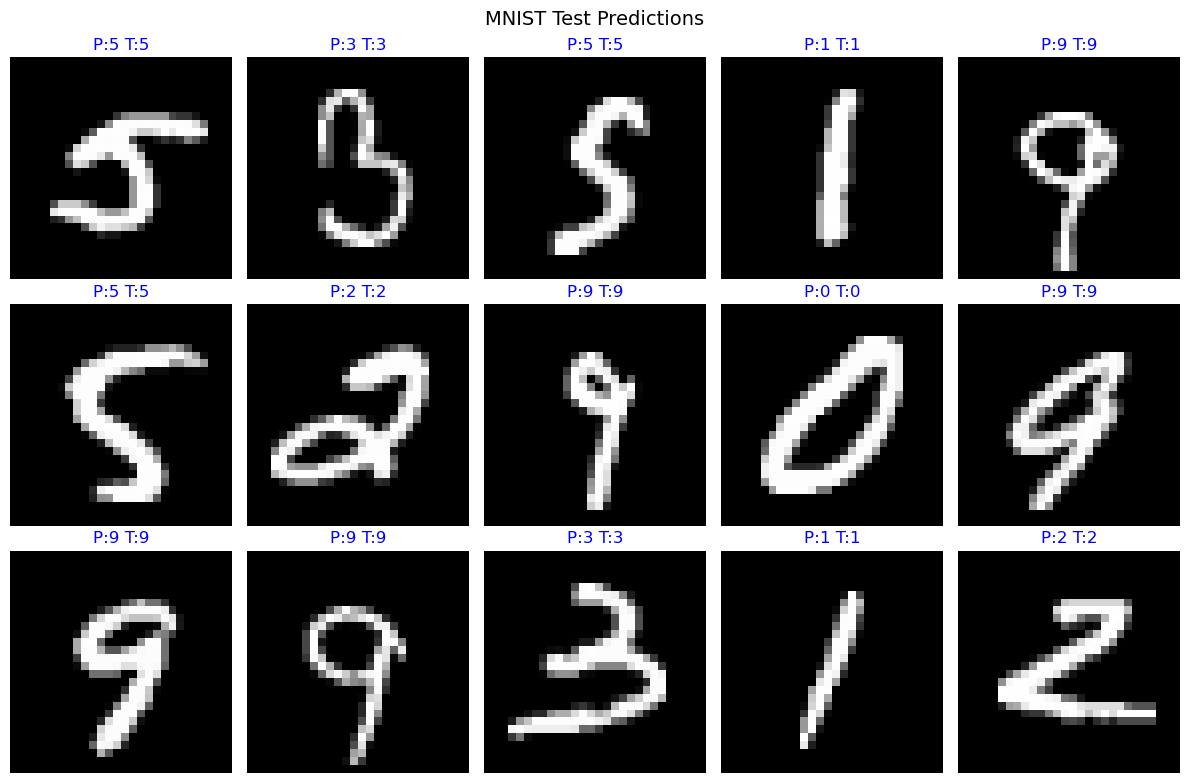

Training completed!


In [10]:
# Test evaluation
print("\nEvaluating on test set...")
model.eval()
test_logits = model(Tensor(X_test))
test_pred = np.argmax(test_logits.data, axis=1)
test_acc = np.mean(test_pred == y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', linewidth=2)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs, 'g-', label="Train", linewidth=2)
plt.plot(val_accs, 'r-', label="Val", linewidth=2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize predictions
num_images = 15
indices = np.random.choice(len(X_test), size=num_images, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(indices):
    image = X_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    
    pred_logits = model(Tensor(X_test[idx:idx+1]))
    pred_label = np.argmax(pred_logits.data)
    
    plt.subplot(3, 5, i + 1)
    plt.imshow(image, cmap='gray')
    color = 'blue' if pred_label == true_label else 'red'
    plt.title(f"P:{pred_label} T:{true_label}", color=color)
    plt.axis('off')

plt.suptitle("MNIST Test Predictions", fontsize=14)
plt.tight_layout()
plt.show()

print("Training completed!")